## Imports

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras import Model
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import MaxPooling2D
from keras.utils.vis_utils import plot_model
from PIL import Image, ImageOps
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os, time, random
import pandas as pd

print(tf.__version__ )

2.4.0


## Dataset download and preprocessing

In [ ]:
import zipfile
from urllib import request

print("Current work directory: {}".format(os.getcwd()))

dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url =  "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"

dataset_path = os.path.join(dataset_folder, "celeba.zip")
dir_data = dataset_folder + "/img_align_celeba"

def download_dataset(download_path, url):
  if not os.path.exists(download_path):
    print("Downloading dataset...")
    request.urlretrieve(url, download_path)
    print("Download complete!")
  else:
    print("Downloaded")


def extract_dataset(download_path, extract_path):
  if not os.path.exists(extract_path + "/img_align_celeba"):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed!")
  else:
    print("Extracted")

# Download
download_dataset(dataset_path, url)

# Extraction
extract_dataset(dataset_path, dataset_folder)


Current work directory: /content
Download complete!
Extracting dataset... (it may take a while...)
Extraction completed!


In [ ]:
preprocessed_path = os.path.join(os.getcwd(), "Preprocessed")
if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)

def crop(path, dest_path):
  if not os.path.isdir(dest_path):
    os.mkdir(dest_path)
  if len(os.listdir(dest_path)) == 0:
    images = os.listdir(path)
    for img_path in images:
      img = Image.open(dir_data + "/" + img_path)
      f, e = os.path.splitext(img_path)
      imCrop = img.crop((25, 45, 128 + 25, 128 + 45)) 
      imCrop.save(dest_path + "/" + f + '.jpg', "JPEG", quality=100)


cropped_path = preprocessed_path + "/cropped_celeba"
crop(dir_data, cropped_path)

In [ ]:
def load_attributes(path):
  df = pd.read_csv(path)
  ids = df['image_id'] 
  attributes = df.drop(columns=['image_id'])
  attributes.replace(to_replace=-1, value=0, inplace=True)
  attributes = attributes.apply(lambda x: x.to_numpy(), axis=1)
  df = pd.DataFrame(columns = ['file_id', 'attributes'])
  df['file_id'] = ids
  df['attributes'] = attributes
  return df
  
attributes = load_attributes(os.path.join("Dataset", "list_attr_celeba.csv"))

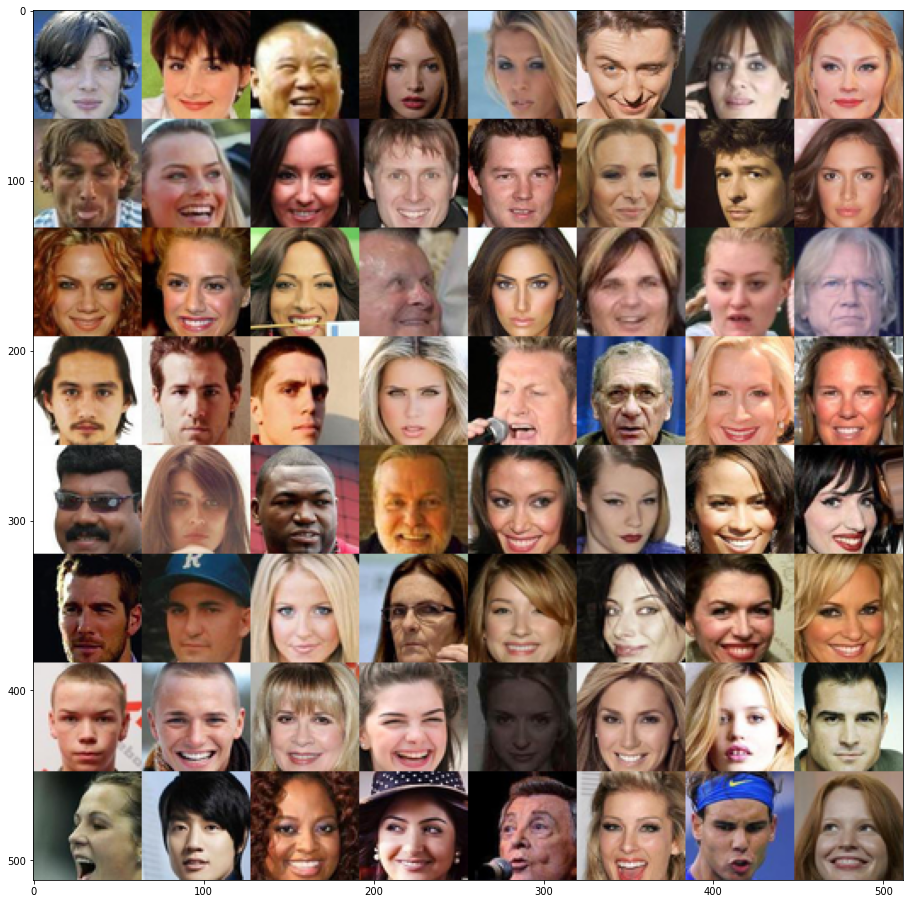

In [ ]:
import random

def concat_images(images, size, shape=None):
    # Open images and resize them
    width, height = size
  
    # Create canvas for the final image with total size
    shape = shape if shape else (1, len(images))
    image_size = (width * shape[1], height * shape[0])
    image = Image.new('RGB', image_size)
    
    # Paste images into final image
    for row in range(shape[0]):
        for col in range(shape[1]):
            offset = width * col, height * row
            idx = row * shape[1] + col
            image.paste(images[idx], offset)
    
    return image

# Get list of image paths
image_paths = [os.path.join(cropped_path, f) 
               for f in os.listdir(cropped_path) if f.endswith('.jpg')]

# Random selection of images
image_array = random.choices(image_paths, k=84)

images = map(Image.open, image_array)
images = [ImageOps.fit(image, (64, 64), Image.ANTIALIAS) 
              for image in images]

# Create and save image grid
image = concat_images(images, (64, 64), (8, 8))
plt.figure(figsize = (16,16))
plt.imshow(image)
image.save('image.jpg', 'JPEG')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

def load_dataset(dataset_path, attributes, batch_size, image_shape, subset=False):
    dataset_generator = ImageDataGenerator()
    if subset:
      dataset_generator = dataset_generator.flow_from_dataframe(
        dataframe=attributes[0:20000], directory=cropped_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size, x_col='file_id', y_col='attributes', class_mode='raw')
    else:
      dataset_generator = dataset_generator.flow_from_dataframe(
          dataframe=attributes, directory=cropped_path, target_size=(image_shape[0], image_shape[1]),
          batch_size=batch_size, x_col='file_id', y_col='attributes', class_mode='raw')

    return dataset_generator

In [ ]:
attributes_list = pd.read_csv(os.path.join('Dataset','list_attr_celeba.csv')).drop(columns=['image_id']).columns
attributes_list = zip(range(0,40), attributes_list)
attributes_dict = dict(attributes_list)
print(attributes_dict)

{0: '5_o_Clock_Shadow', 1: 'Arched_Eyebrows', 2: 'Attractive', 3: 'Bags_Under_Eyes', 4: 'Bald', 5: 'Bangs', 6: 'Big_Lips', 7: 'Big_Nose', 8: 'Black_Hair', 9: 'Blond_Hair', 10: 'Blurry', 11: 'Brown_Hair', 12: 'Bushy_Eyebrows', 13: 'Chubby', 14: 'Double_Chin', 15: 'Eyeglasses', 16: 'Goatee', 17: 'Gray_Hair', 18: 'Heavy_Makeup', 19: 'High_Cheekbones', 20: 'Male', 21: 'Mouth_Slightly_Open', 22: 'Mustache', 23: 'Narrow_Eyes', 24: 'No_Beard', 25: 'Oval_Face', 26: 'Pale_Skin', 27: 'Pointy_Nose', 28: 'Receding_Hairline', 29: 'Rosy_Cheeks', 30: 'Sideburns', 31: 'Smiling', 32: 'Straight_Hair', 33: 'Wavy_Hair', 34: 'Wearing_Earrings', 35: 'Wearing_Hat', 36: 'Wearing_Lipstick', 37: 'Wearing_Necklace', 38: 'Wearing_Necktie', 39: 'Young'}


## Gan section

### Function to save generated images

In [ ]:
generated_images_path = os.path.join(os.getcwd(), "generated images")
if not os.path.exists(generated_images_path):
    os.makedirs(generated_images_path)

def save_generated_images(generated_images, epoch, batch_number, batch_size):

  plt.figure(figsize=(8, 8), num=2)
  gs1 = gridspec.GridSpec(8, 8)
  gs1.update(wspace=0, hspace=0)
  

  for i in range(batch_size):
      ax1 = plt.subplot(gs1[i])
      ax1.set_aspect('equal')
      image = generated_images[i, :, :, :]
      image += 1
      image *= 127.5
      fig = plt.imshow(image.astype(np.uint8))
      plt.axis('off')
      fig.axes.get_xaxis().set_visible(False)
      fig.axes.get_yaxis().set_visible(False)
      #image_array.append(Image.fromarray(image.astype('uint8')))

  plt.tight_layout()
  save_name = 'generated images/epoch_' + str(
      epoch + 1) + '_batch_' + str(batch_number + 1) + '.png'

  plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
  plt.pause(0.0000000001)
  plt.show()

### Wasserstein loss

In [ ]:
from keras import backend

def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

### FID function

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from skimage.transform import resize
from scipy.linalg import sqrtm

def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)


def calculate_fid(model, images1, images2):
	# scale images
	images1_resized = scale_images(images1, (299,299,3))
	images2_resized = scale_images(images2, (299,299,3))
	# calculate activations
	act1 = model.predict(images1_resized)
	act2 = model.predict(images2_resized)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

### Real and Fake data generation

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(2, size=(n_samples, 40))
  #return [x_input, labels]
  return x_input

def generate_real_samples(dataset):
  X, label = dataset.next()
  X /= 127.5
  X -= 1
  y = np.ones(X.shape[0])
  #return [X, label.tolist()], y
  return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  #x_input, labels = generate_latent_points(latent_dim, n_samples)
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  #X = generator.predict([x_input, labels])
  X = generator.predict(x_input)
  # create class labels
  y = np.zeros((n_samples, 1))
  #return [X, labels], y
  return X, y

### Discriminator, Generator and GAN

In [ ]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}


# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), label_shape=(40,), n_attributes=40):
	#input_label = Input(shape=label_shape)
	#n_nodes = in_shape[0] * in_shape[1] * n_attributes
	#dense = Dense(n_nodes)(input_label)
	#reshape = Reshape((in_shape[0], in_shape[1], n_attributes))(dense)
  
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # weight constraint
  const = ClipConstraint(0.01)
 
  input_image = Input(shape=in_shape)
  merge = input_image
	#merge = Concatenate()([input_image, reshape])
	# downsample
  d = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape)(merge)
  d = LeakyReLU(alpha=0.2)(d)
	# downsample
  d = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  #d = BatchNormalization(axis=1)(d)
  d = LeakyReLU(alpha=0.2)(d)
 	# downsample
  d = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  #d = BatchNormalization(axis=1)(d)
  d = LeakyReLU(alpha=0.2)(d)
	# downsample
  d = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # downsample
	#d = Conv2D(256, (3,3), strides=(2,2), padding='same')(d)
	#d = LeakyReLU(alpha=0.2)(d)
	# classifier
  d = Flatten()(d)
  d = Dropout(0.4)(d)
  d = Dense(1, activation='sigmoid')(d)
	# compile model
  opt = RMSprop(learning_rate=0.005)
	#model = Model([input_image, input_label], d)
  model = Model(input_image, d)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
 
# define the standalone generator model
def define_generator(latent_dim, n_attributes=40):
	#input_label = Input(shape=(40,))
	#n_nodes_label = 16 * 16 * n_attributes
	#dense = Dense(n_nodes_label)(input_label)
	#reshape = Reshape((16, 16, n_attributes))(dense)
	# foundation for 8x8 image
  
  # weight initialization
  init = RandomNormal(stddev=0.02)
 
  n_nodes_image = 64 * 16 * 16
  image_input = Input(shape=(latent_dim,))
  gen = Dense(n_nodes_image, input_dim=latent_dim)(image_input)
  gen = Reshape((16, 16, 64))(gen)
  merge = gen
	#merge = Concatenate()([gen, reshape])
	# upsample to 16x16
  conv = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
  #conv = BatchNormalization(axis=1)(conv)
  conv = LeakyReLU(alpha=0.2)(conv)
	# upsample to 32x32
  conv = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv)
  #conv = BatchNormalization(axis=1)(conv)
  conv = LeakyReLU(alpha=0.2)(conv)
	# upsample to 64x64
	# model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	# model.add(LeakyReLU(alpha=0.2))
	# generate
  act = Conv2D(3, (16,16), activation='tanh', padding='same', kernel_initializer=init)(conv)
  #model = Model([image_input, input_label], act)
  model = Model(image_input, act)
  return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
  discriminator.trainable = False
  #gen_image, gen_label = generator.input
  gen_image = generator.input
  gen_output = generator.output
  #gan_output = discriminator([gen_output, gen_label])
  gan_output = discriminator(gen_output)
  #model = Model([gen_image, gen_label], gan_output)
  model = Model(gen_image, gan_output)
	# compile model
  opt = RMSprop(learning_rate=0.005)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

### Train

In [ ]:
import time

# train the generator and discriminator
def train(g_model, d_model, gan_model, inception_model, dataset, latent_dim, n_epochs=10, n_batch=64):
    bat_per_epo = int(202599 / n_batch)
    # manually enumerate epochs
    for i in range(n_epochs):
      start = time.time()
      # enumerate batches over the training set
      for j in range(bat_per_epo):
        # get randomly selected 'real' samples
        #[X_real, labels_real], y_real = generate_real_samples(dataset)
        X_real, y_real = generate_real_samples(dataset)
        current_batch_size = X_real.shape[0]
        # update discriminator model weights
        #labels_real = np.array(labels_real).reshape(current_batch_size,40,1)
        #d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
        d_loss1, _ = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        #[X_fake, labels_fake], y_fake = generate_fake_samples(
        #    g_model, latent_dim, current_batch_size)
        X_fake, y_fake = generate_fake_samples(
            g_model, latent_dim, current_batch_size)
        #labels_fake = np.array(labels_fake).reshape(current_batch_size,40,1)
        # update discriminator model weights
        #d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
        d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, current_batch_size)
        # create inverted labels for the fake samples
        y_gan = np.ones((current_batch_size, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        if ((j + 1) % 200 == 0):
          print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
              (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
          fid = calculate_fid(inception, X_real, X_fake)
          print("Fid score: {:.2f}".format(fid))

        if ((j + 1) % 1000 == 0):
            save_generated_images(X_fake, i, j, n_batch)
      
      end = time.time()
      print("Elapsed time: {:.2f} seconds".format(end-start))
    
    # save the generator model
    g_model.save('generator.h5')
 
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_dataset(cropped_path, attributes, 64, (64,64,3))
# prepare the inception model
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# train model
train(generator, discriminator, gan_model, inception, dataset, latent_dim, n_epochs=15, n_batch=64)

Found 202599 validated image filenames.


KeyboardInterrupt: ignored

In [ ]:
from keras.models import load_model

generator = load_model('generator.h5')
real, _ = generate_real_samples(dataset)
fake, _ = generate_fake_samples(generator, latent_dim, 64)
real_resized = scale_images(real, (299,299,3))
fake_resized = scale_images(fake, (299,299,3))
fid = calculate_fid(inception, real_resized, fake_resized)
print("Fid score: {:.2f}".format(fid))

In [ ]:
 !zip -r /content/generated_images.zip /content/generated\ images
 
from google.colab import files
files.download("/content/generated_images.zip")